In [2]:
import matplotlib.pyplot as plt
import random
import cv2
from assets.data_generator import DR_Generator
import os
from assets.models import SMD_Unet
# from assets.test.models import SMD_Unet
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
import numpy as np

In [14]:
bce = keras.losses.BinaryCrossentropy()

def dice_coef(y_true, y_pred, smooth=1.): 
    y_true = tf.cast(y_true, dtype='float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_coef = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    return dice_coef

def dice_loss(y_true, y_pred, smooth=1.): 
    dice = dice_coef(y_true, y_pred, smooth)
    dice_loss = 1 - dice
    return dice_loss

def mean_square_error(input_hats, inputs):        
    mses = []

    for input_hat, input in zip(input_hats, inputs):
        mses.append(tf.reduce_mean(tf.square(input_hat - input)))

    result = tf.reduce_mean(mses) # 배치 나눠서 계산하고 평균해주기
    return tf.cast(result, dtype=tf.float32)

In [4]:
os.listdir('../data/Seg-set')

['IRMA_Masks',
 'Original_Images',
 'HardExudate_Masks',
 'SoftExudate_Masks',
 'Microaneurysms_Masks',
 'Hemohedge_Masks',
 'DR_Seg_Grading_Label.csv',
 'Neovascularization_Masks']

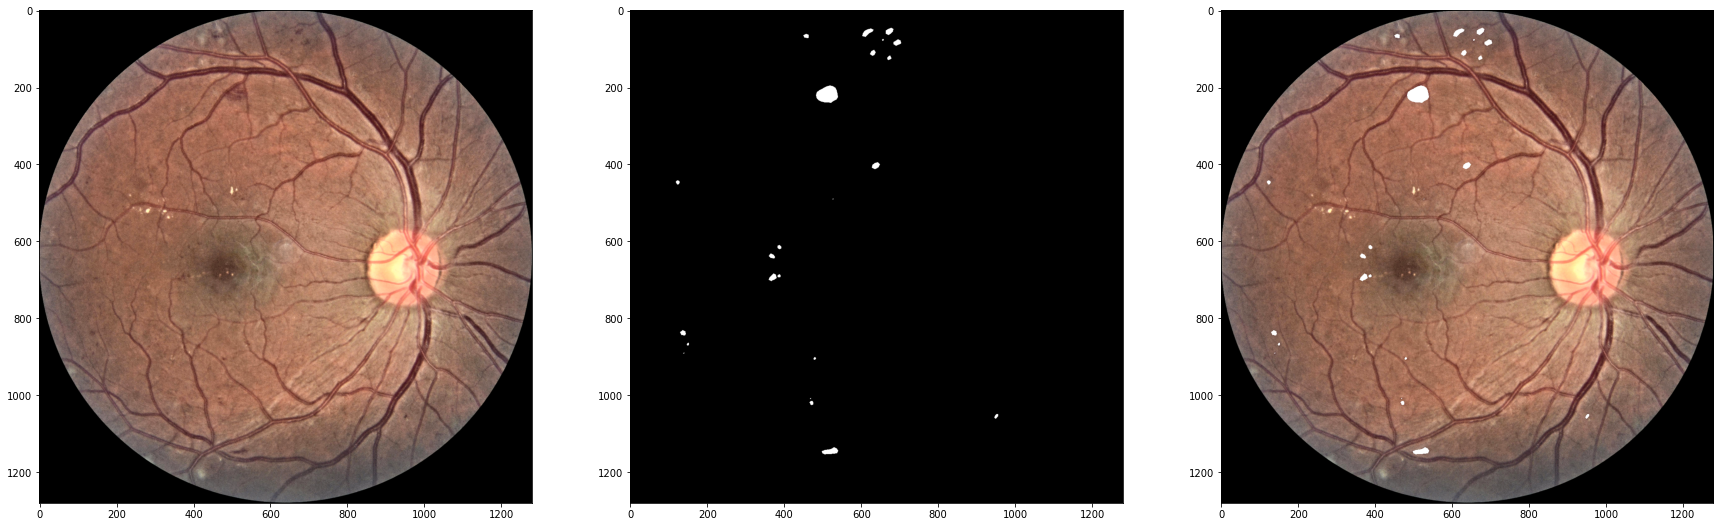

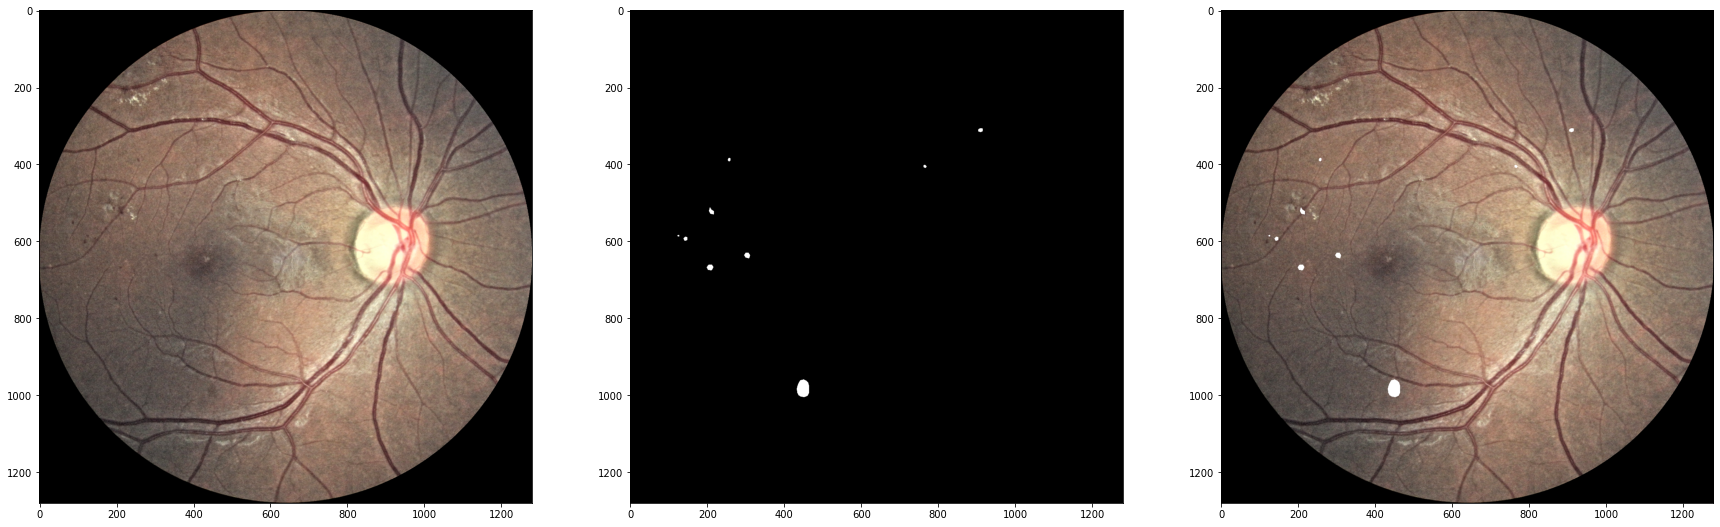

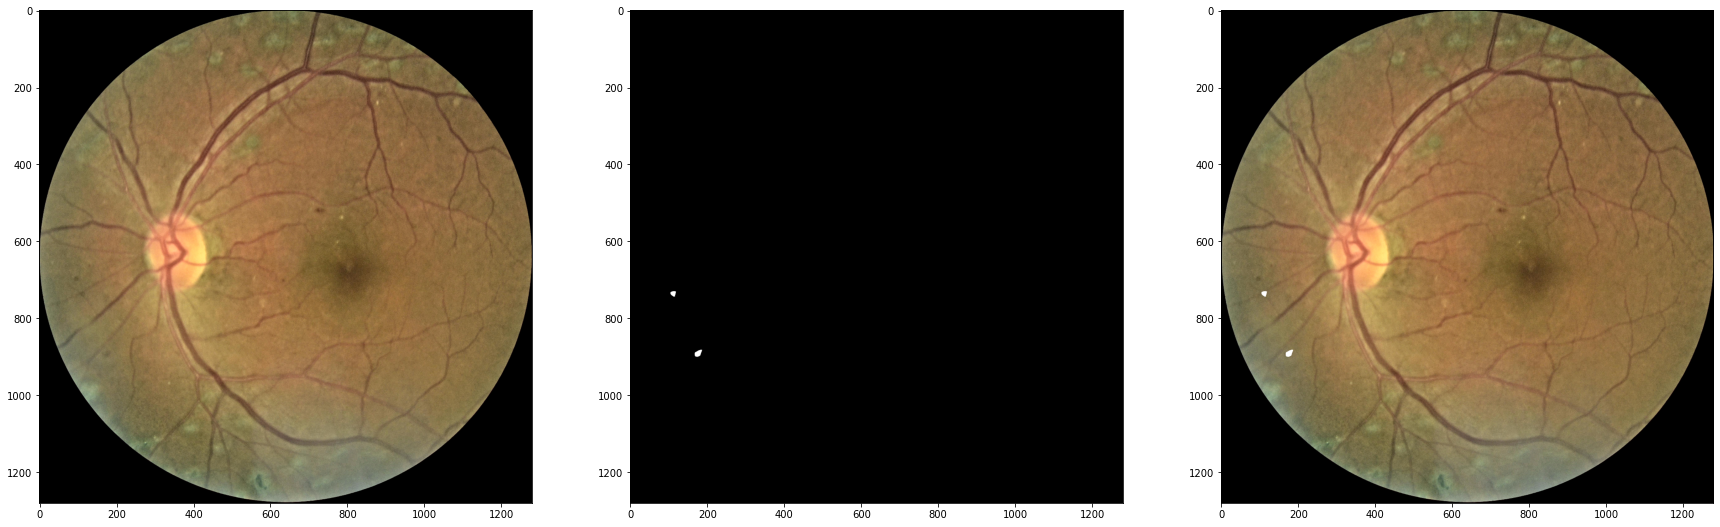

In [5]:
image_path = '../data/Seg-set/Original_Images'
mask_path = '../data/Seg-set/Hemohedge_Masks/'

files = os.listdir(image_path)

for _ in range(3):
    file = random.choice(files)
    image = cv2.imread(os.path.join(image_path, file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(os.path.join(mask_path, file))
    # mask[0][mask[0] > 0] = 255

    plt.figure(figsize=(30, 30))

    plt.subplot(1, 3, 1)
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.add(image, mask))

    plt.show()

In [6]:
masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_dir = '../data/Seg-set/'
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

generator_args = {
    'dir_path':'../data/Seg-set/Original_Images/',
    'mask_path':mask_paths,
    'use_mask':True,
    'img_size':(512, 512),  
    'batch_size':4, # 8로 하면 바로 OOM 뜸
    'dataset':'FGADR', # FGADR or EyePacks
    'use_3channel':False,
    'CLAHE_args':None,
    'add_noise_std':None
}

tr_fgadr_gen = DR_Generator(start_end_index=(0, 1292), is_train=True, **generator_args)
val_fgadr_gen = DR_Generator(start_end_index=(1292, 1476), is_train=False, **generator_args)
ts_fgadr_gen = DR_Generator(start_end_index=(1476, 1842), is_train=False, **generator_args)

In [7]:
os.listdir('../models')

['with_recons_3channel_no_CLAHE.data-00000-of-00001',
 '.ipynb_checkpoints',
 'without_recons_1channel_no_lr01.index',
 'pretraining_addNoise_03.index',
 'with_recons_1channel_CLAHE.data-00000-of-00001',
 'without_recons_1channel_no_CLAHE_testModel.data-00000-of-00001',
 'without_recons_1channel_no_lr01.data-00000-of-00001',
 'checkpoint',
 'without_recons_1channel_no_CLAHE_testModel.index',
 'with_recons_1channel_CLAHE.index',
 'with_recons_3channel_CLAHE.data-00000-of-00001',
 'pretraining_addNoise_03.data-00000-of-00001',
 'with_recons_3channel_CLAHE.index',
 'with_recons_3channel_no_CLAHE.index']

In [17]:
model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=1)
# model.load_weights('../models/without_recons_1channel_no_lr01')

In [18]:
for inputs, targets, in val_fgadr_gen:
    break

In [20]:
with tf.GradientTape() as tape:
    preds = model(inputs[0])
    mask_loss = dice_loss(targets, preds[1], smooth=100.0)
    bce_loss = tf.cast(bce(np.where(targets==0, 1, 0), 1-preds[1]), dtype='float32')
    mse_loss = mean_square_error(targets, preds[1])
    train_loss = mask_loss + bce_loss
    
grads = tape.gradient(bce_loss, model.trainable_weights)  # gradient 계산
grads

[<tf.Tensor: shape=(3, 3, 1, 64), dtype=float32, numpy=
 array([[[[ 6.37106178e-03, -2.76420498e-03, -2.19035777e-03,
           -9.64468170e-04,  1.94355380e-04,  8.27973150e-03,
           -4.60997748e-04, -1.74666988e-03,  3.31330858e-03,
            3.09717643e-06, -9.69614234e-07, -1.11978252e-05,
            5.59208183e-06, -1.12498738e-03, -1.76766794e-02,
            1.14086475e-02, -9.98756150e-06, -1.09019948e-06,
           -1.73240416e-02, -5.76805277e-03,  2.19495405e-06,
           -3.14486824e-05, -2.80598318e-03, -1.08972243e-04,
            6.75834508e-06, -1.10720121e-03, -1.68162130e-03,
           -7.21076876e-03, -8.82681732e-08, -6.59805071e-03,
           -1.78902340e-03,  1.73625249e-05,  1.39405784e-05,
           -2.00605369e-03,  3.76821822e-03, -3.28377378e-03,
           -4.17209662e-08,  8.79110416e-07,  3.49080219e-05,
           -1.34677815e-04,  2.64453678e-03, -8.42021545e-05,
            6.02197507e-03,  8.33164342e-03,  1.43942400e-03,
           -8.

In [13]:
model.build(input_shape=(None, 512, 512, 1))

In [14]:
model.summary()

Model: "smd__unet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block_1 (EncoderBloc multiple                  83869632  
_________________________________________________________________
decoder_block_2 (DecoderBloc multiple                  50009964  
_________________________________________________________________
decoder_block_3 (DecoderBloc multiple                  50009964  
Total params: 183,889,560
Trainable params: 183,874,704
Non-trainable params: 14,856
_________________________________________________________________


In [15]:
model.encoder.get_weights()

[array([[[[-3.54084000e-02,  7.36813918e-02, -1.90325841e-01,
            4.86364782e-01,  2.31017962e-01,  5.10447502e-01,
           -4.32828099e-01, -3.92238557e-01, -3.72142792e-01,
            5.08543432e-01, -8.54815841e-02,  2.46970840e-02,
           -4.40535247e-01, -4.91956733e-02, -1.17478788e-01,
           -3.03459674e-01, -1.02563724e-01,  1.42694548e-01,
           -3.13141555e-01,  3.14709216e-01, -4.00344670e-01,
           -4.39531058e-02,  2.43970118e-02, -2.27341205e-01,
           -2.59873271e-01,  3.51709388e-02,  3.73100907e-01,
            2.36134678e-02, -5.07032692e-01,  4.63242859e-01,
           -7.41588995e-02, -3.02057099e-02, -2.46137250e-02,
            4.50498581e-01,  4.43011969e-01,  1.24252856e-01,
            3.84802490e-01,  5.98749965e-02, -4.74595785e-01,
            2.39339396e-01,  1.37986168e-01,  3.07876527e-01,
            7.21970648e-02, -9.43731442e-02, -9.78716165e-02,
           -7.93059319e-02, -2.24593226e-02, -4.76163626e-01,
        

In [11]:
model.reconstruction.get_weights()

[array([[[[ 0.02721371,  0.02434201, -0.01553494, ..., -0.02111305,
           -0.00527555,  0.00267482],
          [ 0.02863963,  0.02095957,  0.02542164, ..., -0.02382841,
            0.01872513, -0.01980923],
          [-0.00051682,  0.01057231,  0.00662956, ...,  0.0210297 ,
            0.02923262,  0.02155965],
          ...,
          [ 0.00343802,  0.00918039,  0.01679403, ..., -0.02297192,
            0.01798613, -0.02229067],
          [ 0.01513442,  0.02975177,  0.01335736, ...,  0.02724335,
            0.01775706,  0.00372124],
          [ 0.02924776, -0.00860187,  0.03118179, ..., -0.01171719,
           -0.00250463, -0.0018505 ]],
 
         [[ 0.0185056 ,  0.00516175,  0.00944991, ...,  0.02667714,
            0.01882758,  0.02689051],
          [ 0.00715851, -0.00333018, -0.00938681, ..., -0.01668607,
           -0.01802985, -0.0242401 ],
          [-0.00970528,  0.01957218,  0.02536905, ..., -0.02966184,
           -0.00737324, -0.01888234],
          ...,
          [ 0

In [17]:
model.decoder.get_weights()

[array([[[[-0.00310931, -0.00474157, -0.00311941, ..., -0.02019357,
            0.00113442, -0.0075019 ],
          [-0.03000061, -0.00167642, -0.02415601, ...,  0.03119269,
            0.00811607, -0.0067316 ],
          [ 0.01000946, -0.01473293, -0.00588998, ..., -0.01072681,
            0.00939687,  0.02875958],
          ...,
          [ 0.00160513, -0.00642975,  0.01824496, ...,  0.02039805,
            0.00018976,  0.00582529],
          [-0.01874294,  0.02873518, -0.01054882, ...,  0.01210796,
            0.01686536,  0.02878074],
          [-0.0033668 , -0.0140492 , -0.01880065, ..., -0.01820666,
           -0.00685145, -0.0189568 ]],
 
         [[ 0.01277611,  0.00103765,  0.02831444, ..., -0.00157065,
           -0.01428319, -0.02517701],
          [ 0.02596898, -0.02439502,  0.0157801 , ..., -0.00023892,
            0.01239545, -0.01312764],
          [-0.01797174,  0.01341482,  0.01073815, ..., -0.02643646,
           -0.02783863,  0.02495454],
          ...,
          [-0

In [56]:
mask_loss

<tf.Tensor: shape=(), dtype=float64, numpy=0.9100873917341232>

In [48]:
bce(mask, mask_hat)

<tf.Tensor: shape=(), dtype=float32, numpy=8.21711>

In [54]:
bce = keras.losses.BinaryCrossentropy()
bce(np.where(mask == 0, 1, 0), 1- mask_hat)

<tf.Tensor: shape=(), dtype=float32, numpy=8.21711>

In [39]:
bce = keras.losses.BinaryCrossentropy()
bce(mask, mask_hat)

<tf.Tensor: shape=(), dtype=float32, numpy=8.21711>

tf.Tensor(0.9782475512474775, shape=(), dtype=float64)


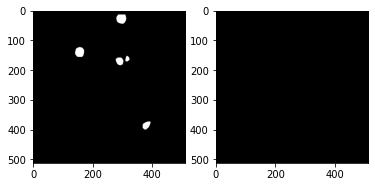

tf.Tensor(0.9729843456298113, shape=(), dtype=float64)


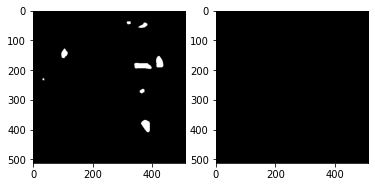

tf.Tensor(0.7400168478488922, shape=(), dtype=float64)


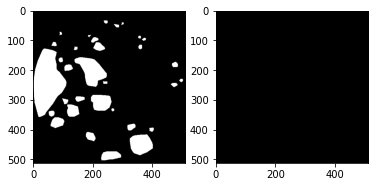

tf.Tensor(0.9723682943731546, shape=(), dtype=float64)


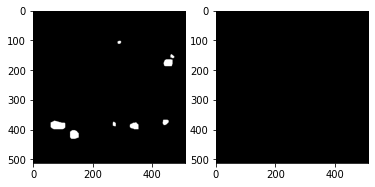

In [36]:
mask_hats = preds[1].numpy()

for mask, mask_hat in zip(targets, mask_hats):
    print(dice_loss(mask, mask_hat))
    plt.subplot(1, 2, 1)
    plt.imshow(mask * 255, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(mask_hat * 255, cmap='gray')
    plt.show()

In [13]:
def dice_loss(y_true, y_pred, smooth=1.): 
    y_true = tf.cast(y_true, dtype='float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    dice_loss = 1 - dice

    return tf.cast(dice_loss, dtype=tf.float64)

In [14]:
targets[2].shape

(512, 512, 1)

In [15]:
y_pred_f = K.flatten(mask_hats[2])
y_true_f = K.flatten(tf.cast(targets[2], dtype='float32'))

tf.reduce_sum(y_pred_f * y_true_f)

<tf.Tensor: shape=(), dtype=float32, numpy=1123.3911>

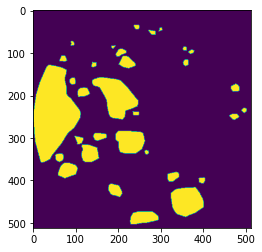

In [16]:
plt.imshow(tf.cast(targets[2], dtype='float32').numpy())

In [17]:
mask_hats[2]

array([[[0.02556851],
        [0.02556851],
        [0.02556851],
        ...,
        [0.02556851],
        [0.02556851],
        [0.02556851]],

       [[0.02556851],
        [0.02556851],
        [0.02556851],
        ...,
        [0.02556851],
        [0.02556851],
        [0.02556851]],

       [[0.02556851],
        [0.02556851],
        [0.02556851],
        ...,
        [0.02556851],
        [0.02556851],
        [0.02556851]],

       ...,

       [[0.02556851],
        [0.02556851],
        [0.02556851],
        ...,
        [0.02556851],
        [0.02556851],
        [0.02556851]],

       [[0.02556851],
        [0.02556851],
        [0.02556851],
        ...,
        [0.02556851],
        [0.02556851],
        [0.02556851]],

       [[0.02556851],
        [0.02556851],
        [0.02556851],
        ...,
        [0.02556851],
        [0.02556851],
        [0.02556851]]], dtype=float32)

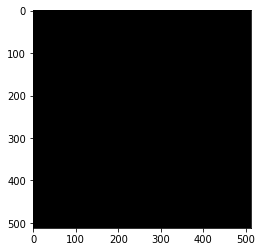

In [18]:
test = mask_hats[2].copy()
test[test != 0] = 255
plt.imshow(test, cmap='gray')

In [95]:
(mask_hats[2] != 0).sum()

262144

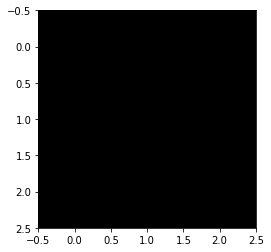

In [102]:
plt.imshow([[0.99975985, 0.99975985, 0.99975985], [0.99975985, 0.99975985, 0.99975985], [0.99975985, 0.99975985, 0.99975985]], cmap='gray')

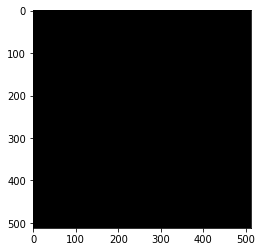

In [72]:
plt.imshow(mask_hats[2], cmap='gray')

In [52]:
K.flatten(mask_hats[2])

<tf.Tensor: shape=(262144,), dtype=float32, numpy=
array([0.99975985, 0.99975985, 0.99975985, ..., 0.99975985, 0.99975985,
       0.99975985], dtype=float32)>

In [51]:
K.flatten(targets[2])

<tf.Tensor: shape=(262144,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>

In [41]:
targets[2].sum()

39169.0